In [1]:
import sys
import os

In [2]:
from deeplate.MMdata import MMData 
import numpy as np
import matplotlib.pyplot as plt
import re
import scipy.ndimage as nd

from skimage.measure import label, regionprops
from skimage import morphology
from skimage.color import label2rgb
import pandas as pd

In [3]:
import deeplate.platesegmenter as ps

/scicore/home/nimwegen/witzg/DeepPlateSegmenter/venv-deeplate/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
#folder = '/Volumes/MusiqueHD/201710126_lowerbound'
#folder = '/scicore/home/nimwegen/urchuegu/projects/prj_noise_across_conditions_main/cell_size/data/20170126/201710126_lowerbound/'
#folder = '/scicore/home/nimwegen/urchuegu/projects/prj_noise_across_conditions_main/cell_size/data/20170330/20170330_highmed_1/'
folder = '/scicore/home/nimwegen/urchuegu/projects/prj_noise_across_conditions_main/cell_size/data/20180315/20180315_styph24h_M02_3'

In [5]:
#where to find the weights for the CNN
# #weights_folder  = '/Users/guillaume/Desktop/PostdocBasel/PlateSegmenter_Python_Git/DeepPlate/Learn201710126/'
# weights_folder  = '/scicore/home/nimwegen/witzg/DeepLearningData/Learn20170126_subset_stack2/'
weights_folder = '/scicore/home/nimwegen/GROUP/MM_Data/DeepLearning/96Plates/'

In [6]:
#where to save the analysis
folder_to_save = '/scicore/home/nimwegen/witzg/DeepPlateAnalysis/'

In [7]:
#print recorded channels 
MMobj = MMData(folder = folder)
print(MMobj.channels)

['DIA (Dual)', 'GFP (Dual noPh3)']


In [8]:
#based on the above outpout set fluo and bright field channels
fluo_ch = 1
bf_ch = 0

In [9]:
#load deep learning model and weights
plate_model = ps.get_unet(10, 304,304)
plate_model.load_weights(weights_folder+'/weights.h5')

In [10]:
#get metadata
z_step = MMobj.get_zstep()
positions, well = MMobj.get_position_names()
well_str = [re.findall('(.*?)-.*',x)[0] for x in positions]

In [11]:
#find index of specific position 
positions.index("C2-Site_1")

61

In [12]:
#choose which positions to analyze. E.g. [3,8,24]
chosen_index = [0]

In [13]:
#middle plane of bf stack
mid = (MMobj.num_planes[bf_ch]-1)/2

1/1 [==============================] - 0s 211ms/step


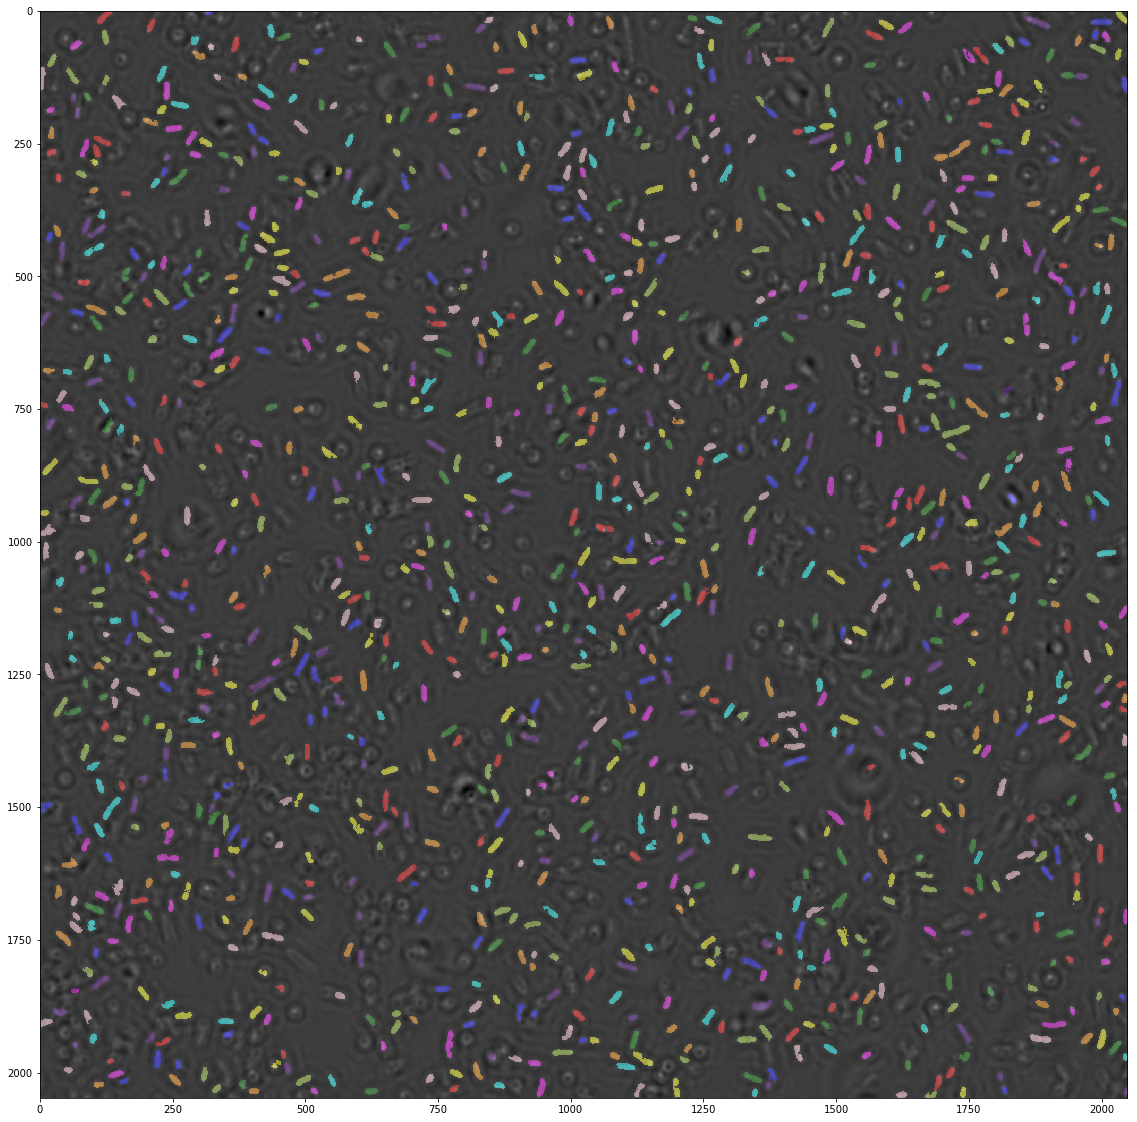

In [14]:
#create folder to save data
if not os.path.exists(folder_to_save):
    os.makedirs(folder_to_save)

#do the segmentation
for i in range(len(chosen_index)):#range(len(positions)):
    
    #load bf stack
    stack = np.empty((MMobj.height,MMobj.width, 10))
    for j in range(10):
        plane = mid-5+j
        stack[:,:,j] = MMobj.get_image(frame=0,channel=bf_ch,plane = plane,position=chosen_index[i], compress = 1)
        stack[:,:,j] = nd.gaussian_filter(stack[:,:,j],3)
    
    meanstack = np.mean(stack,axis =2)
    for m in range(stack.shape[2]):
        stack[:,:,m] = stack[:,:,m]-meanstack
    
    
    stack = stack/np.std(stack)
    
    #load fluo image
    im_fluo = MMobj.get_stack(frame=0,channel=fluo_ch,position=chosen_index[i], compress = 1)[:,:,0]
    
    complete = np.empty((MMobj.height,MMobj.width))
    complete_proba = np.empty((MMobj.height,MMobj.width))
    
    topad = 24
    stack = np.pad(stack,((topad,topad),(topad,topad),(0,0)),mode = 'constant')
    for k in range(8):
        for m in range(8):
            
            
            stack_cur = stack[k*256:(k+1)*256+2*topad,m*256:(m+1)*256+2*topad,:]

            plate_im = stack_cur[np.newaxis,...]
            plate_im_mask = plate_model.predict(plate_im, verbose=1)
            plate_im_mask = np.reshape(plate_im_mask,[256+2*topad,256+2*topad])
            complete_proba[k*256:(k+1)*256,m*256:(m+1)*256] = plate_im_mask[topad:-topad,topad:-topad]
    
    stack = stack[topad:-topad,topad:-topad,:]
    complete = complete_proba.copy()
    
    #make a mask using a low threshold to capture all the pixels of cells. 
    #however pick then cells whose "best" pixel has relatively high probability
    complete[complete<0.2]=0
    complete[complete>0.2]=1
    masklab = morphology.label(complete)
    cellinfo = regionprops(masklab, im_fluo)  
    cellinfo2 = regionprops(masklab, complete_proba)  
    newMask = np.zeros(masklab.shape)
    for x in range(len(cellinfo)):
        c = cellinfo[x]
        c2 = cellinfo2[x]
        if (c.label>0)&(c.area>100)&(c.area<10000)&(c.solidity>0.8)&(c.eccentricity>0.6)&(c2.max_intensity>0.8):
            newMask[masklab==c.label]=1
    
    #calculate local properties
    complete_lab = label(newMask)
    cell_info = regionprops(complete_lab,im_fluo)
    
    mean_int = [x.mean_intensity for x in cell_info]
    posx = [x.centroid[0] for x in cell_info]
    posy = [x.centroid[1] for x in cell_info]
    sum_int = [np.sum(im_fluo[complete_lab==x.label]) for x in cell_info]
    all_pix = [im_fluo[complete_lab==x.label] for x in cell_info]
    area = [x.area for x in cell_info]
    #create a dataframe
    cell_struct = {'sum_fluo': sum_int,'mean_fluo':mean_int,'area': area, 'posx': posx, 'posy': posy,'all_pix':all_pix}
    cell_frame = pd.DataFrame(cell_struct)
    cell_frame['pos_name'] = positions[i]
    cell_frame['well_name'] = well_str[i]
    
    cell_frame.to_csv(folder_to_save+'/'+positions[i]+'.csv')
    
    #save image
    fig, ax = plt.subplots(figsize=(20,20))
    plt.imshow(stack[:,:,0],cmap='gray')
    plt.imshow(label2rgb(label(newMask),bg_label=0),alpha = 0.4)
    plt.show()
    fig.savefig(folder_to_save+'/'+positions[i]+'seg.png')

In [ ]:
#plot things with ggplot2

In [ ]:
#only for GW mac
#%%bash 
#export SUDO_ASKPASS=/Applications/Utilities/XQuartz.app/Contents/MacOS/X11
#ln -sfhv /Library/Frameworks/R.framework/Versions/3.3 /Library/Frameworks/R.framework/Versions/Current

In [ ]:
%load_ext rpy2.ipython
%R require(ggplot2)

/scicore/home/nimwegen/witzg/.local/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

  warnings.warn(x, RRuntimeWarning)


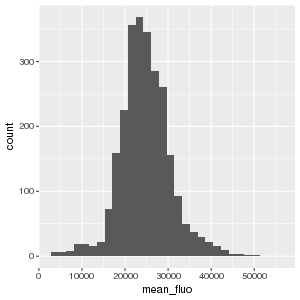

In [18]:
%%R -i cell_frame,folder_to_save -w 300 -h 300 -u px
x<-ggplot(NULL)+
geom_histogram(data=cell_frame,aes(x=mean_fluo))
print(x)

#location<-paste(folder_to_save,cell_frame[0,'position'],'.Rda',sep = "")
#save(cell_frame,file=location)